In [109]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import urllib.request
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
%matplotlib inline



In [79]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

In [84]:
mdcw_catalog[1].data['name']

chararray(['MOO J0001+1428', 'MOO J0001+3644', 'MOO J0001+3440', ...,
           'MOO J2348+0508', 'MOO J2355+1030', 'MOO J2358+1931'],
          dtype='<U14')

In [71]:
def stack(ras, decs, map1, mask1, map2 = None, mask2 = None, width = 20.):
        stack = 0
        divisor = 0
        for i in range(len(ras)):
                tempdec, tempra = np.deg2rad([decs[i], ras[i]])
                tempwid = np.deg2rad(width/60.)
                box = [[tempdec-tempwid,tempra-tempwid],[tempdec+tempwid,tempra+tempwid]]
                maskstamp = mask1.submap(box)
                #Check if the stamp is entirely within borders, i.e. if the mask stamp is entirely ones
                if np.any(maskstamp[0]):
                        stamp = reproject.postage_stamp(map1, ras[i], decs[i], width, 0.5)
                        if stamp is None: continue
                        stack += stamp[0]
                        divisor += 1
                        continue
                if map2 is None: continue
                #If a second map is to be checked, repeat above with second map
                maskstamp = mask2.submap(box)
                if np.any(maskstamp[0]):
                        #print(i)
                        stamp = reproject.postage_stamp(map2, ras[i], decs[i], width, 0.5)
                        if stamp is None: continue
                        stack += stamp[0]
                        divisor += 1

        stack /= divisor
        print("Number in stack: {}".format(divisor))
        return stack, divisor


Number in stack: 944


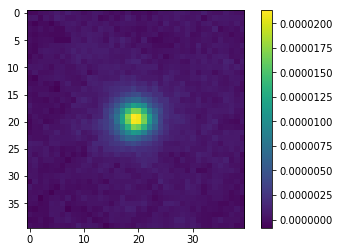

In [66]:
mappath = '/scratch/r/rbond/msyriac/data/depot/tilec/v1.2.0_20200324/map_v1.2.0_joint_boss/'

t = QTable.read('madcows/AdvACT_S18Clusters_v1.0-beta.fits')

boss_mask = enmap.read_map(mappath + "tilec_mask.fits")
boss_map = enmap.read_map(mappath + 'tilec_single_tile_boss_comptony_map_v1.2.0_joint.fits')

ra_temp = t['RADeg']
dec_temp = t['decDeg']
ra, dec = np.array(ra_temp), np.array(dec_temp)

boss_stack = stack(ra, dec, boss_map, boss_mask)
plt.imshow(boss_stack)
plt.colorbar()
plt.show()
#plt.savefig("boss_stack_act_y.png")
plt.close()




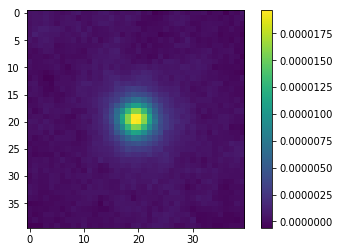

In [17]:
#plots = enplot.plot(enmap.upgrade(boss_stack,5),grid=False, colorbar=True,color='gray')
#enplot.write("boss_stack_act_y",plots)

d56_path = '/scratch/r/rbond/msyriac/data/depot/tilec/v1.2.0_20200324/map_v1.2.0_joint_deep56/'

d56_mask = enmap.read_map(d56_path + "tilec_mask.fits")
d56_map = enmap.read_map(d56_path + 'tilec_single_tile_deep56_comptony_map_v1.2.0_joint.fits')


d56_stack = stack(ra, dec, d56_map, d56_mask)
plt.imshow(d56_stack)
plt.colorbar()
plt.show()
#plt.savefig("d56_stack_act_y.png")
plt.close()




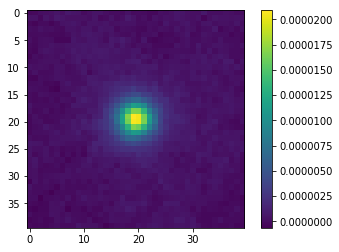

In [18]:
comb_stack = stack(ra, dec, boss_map, boss_mask, d56_map, d56_mask)
plt.imshow(comb_stack)
plt.colorbar()
plt.show()
#plt.savefig("comb_stack_act_y.png")
plt.close()

Number above cut: 2839
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number in stack: 379
4.19969463215e-07
2.37746059734e-07


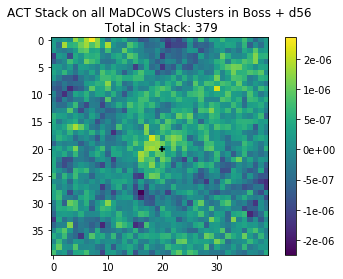

In [151]:
mdcw_ra = mdcw_catalog[1].data['RADeg']
mdcw_dec =mdcw_catalog[1].data['decDeg']
mdcw_ra, mdcw_dec = np.array(mdcw_ra), np.array(mdcw_dec)
mdcw_rich = mdcw_catalog[1].data['Rich']

in_act = ['MOO J0018+0000','MOO J0019+0209','MOO J0028-1005','MOO J0048+1757','MOO J0101+0030','MOO J0102+0201','MOO J0105+1324','MOO J0105-1839','MOO J0120-0304','MOO J0125-0802','MOO J0129-1640','MOO J0132+0329','MOO J0136-0959','MOO J0208-0935','MOO J0234-0107','MOO J0239-1035','MOO J0300+0124','MOO J0303+1857','MOO J0308-2915','MOO J0353+0832','MOO J0448-1705','MOO J0846+1504','MOO J0934+1751','MOO J0936+0337','MOO J1014+0038','MOO J1029+0017','MOO J1048+0743','MOO J1053+1052','MOO J1140+1522','MOO J1142+1346','MOO J1142+1527','MOO J1149+0921','MOO J1204+1525','MOO J1208+0501','MOO J1241+0011','MOO J1254+0948','MOO J1310+1707','MOO J1322-0228','MOO J1346-0142','MOO J1354+1329','MOO J1355+1606','MOO J1414+0227','MOO J1418+0723','MOO J1424-0141','MOO J1454+0628','MOO J1455+0439','MOO J1514+1346','MOO J1521+0452','MOO J1525+1541','MOO J1536+0953','MOO J1620+1340','MOO J2146-0320','MOO J2205-2955','MOO J2231+1130','MOO J2235+1320','MOO J2316+0920','MOO J2319-1856','MOO J2358+1836']

names = mdcw_catalog[1].data['name']

flags = [True]*len(mdcw_ra)

for i, name in enumerate(names):
    #print(name)
    if name in in_act:
        #print(i)
        flags[i] = False

print("Number above cut: {}".format(len(mdcw_ra)))

print("Number before confirmed removal: {}".format(len(mdcw_ra)))
mdcw_ra = mdcw_ra[flags]
mdcw_dec = mdcw_dec[flags]
mdcw_rich = mdcw_rich[flags]
print("Number after confirmed removal: {}".format(len(mdcw_ra)))

mdcw_stack, stack_num = stack(mdcw_ra, mdcw_dec, boss_map, boss_mask, d56_map, d56_mask)

for i in range(len(mdcw_stack[0])):
    for j in range(len(mdcw_stack[0])):
        if (27<i<33) & (27<j<33):
            cen += mdcw_stack[i][j]
            cen_d += 1
        else:
            out += mdcw_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)

plot = plt.imshow(mdcw_stack)
plt.scatter(20,20, marker = '+', color = 'k')
plt.colorbar(plot, format='%.0e')
plt.title("ACT Stack on all MaDCoWS Clusters in Boss + d56\n Total in Stack: {}".format(stack_num))
plt.savefig("mdcw_stack_act_y.png")
plt.show()
plt.close()

Number above cut: 261
Number in stack: 31
1.27014799603e-06
5.35791251041e-07


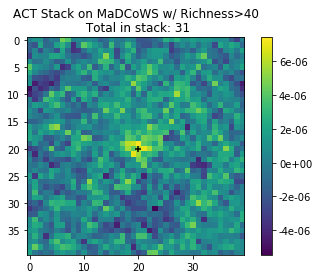

In [152]:
#print(mdcw_catalog[1].header)


rich_cut = 40
mdcw_cut = np.where((rich_cut<np.array(mdcw_rich)) & (np.array(mdcw_rich)<1000))[0]


print("Number above cut: {}".format(len(mdcw_cut)))

mdcw_cut_ra = mdcw_ra[mdcw_cut]
mdcw_cut_dec = mdcw_dec[mdcw_cut]

mdcw_stack, stack_num = stack(mdcw_cut_ra, mdcw_cut_dec, boss_map, boss_mask, d56_map, d56_mask)

#print('Average in central 10x10: {}'.format(np.mean(mdcw_stack[25:35][25:35])))
#print(mdcw_stack[0][25:35])
cen, out, cen_d, out_d = 0, 0, 0, 0

for i in range(len(mdcw_stack[0])):
    for j in range(len(mdcw_stack[0])):
        if (27<i<33) & (27<j<33):
            cen += mdcw_stack[i][j]
            cen_d += 1
        else:
            out += mdcw_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)

plot = plt.imshow(mdcw_stack)
plt.colorbar(plot, format='%.0e')
plt.scatter(20,20, marker = '+', color = 'k')
plt.title("ACT Stack on MaDCoWS w/ Richness>{}\n Total in stack: {}".format(rich_cut, stack_num))
plt.savefig("mdcw_cut_stack_act_y.png")
plt.show()
plt.close()

In [115]:
print(mdcw_catalog[1].data['name'])


['MOO J0001+1428' 'MOO J0001+3644' 'MOO J0001+3440' ..., 'MOO J2348+0508'
 'MOO J2355+1030' 'MOO J2358+1931']


MOO J0018+0000
MOO J0019+0209
MOO J0028-1005
MOO J0048+1757
MOO J0101+0030
MOO J0102+0201
MOO J0105+1324
MOO J0105-1839
MOO J0120-0304
MOO J0125-0802
MOO J0129-1640
MOO J0132+0329
MOO J0136-0959
MOO J0208-0935
MOO J0234-0107
MOO J0239-1035
MOO J0300+0124
MOO J0303+1857
MOO J0308-2915
MOO J0353+0832
MOO J0448-1705
MOO J0846+1504
MOO J0934+1751
MOO J0936+0337
MOO J1014+0038
MOO J1029+0017
MOO J1048+0743
MOO J1053+1052
MOO J1140+1522
MOO J1142+1346
MOO J1142+1527
MOO J1149+0921
MOO J1204+1525
MOO J1208+0501
MOO J1241+0011
MOO J1254+0948
MOO J1310+1707
MOO J1322-0228
MOO J1346-0142
MOO J1354+1329
MOO J1355+1606
MOO J1414+0227
MOO J1418+0723
MOO J1424-0141
MOO J1454+0628
MOO J1455+0439
MOO J1514+1346
MOO J1521+0452
MOO J1525+1541
MOO J1536+0953
MOO J1620+1340
MOO J2146-0320
MOO J2205-2955
MOO J2231+1130
MOO J2235+1320
MOO J2316+0920
MOO J2319-1856
MOO J2358+1836
58
